# TASBE Workflow Example

This notebook demonstrates using `cytoflow` for doing calibrated flow cytometry, converting the arbitrary units from the flow cytometer to Molecules Equivalent Fluorescein (MEFLs).

``cytoflow``'s implementation closely follows that described in [Beal et al](http://dspace.mit.edu/handle/1721.1/69973) and its application in [Davidsohn et al.](http://pubs.acs.org/doi/abs/10.1021/sb500263b)  It consists of four steps:

* Autofluorescence correction.
* Spectral bleedthrough correction (aka compensation).
* Calibration to physical units (MEFLs, etc.)
* Mapping to common logical units (MEFLs in the FITC channel).

Each step requires a particular set of controls.  They'll be described in more detail below, but they are (in short):
* Blank (unstained, untransfected, untransformed) cells (to do autofluorescence removal)
* One-color controls for each channel (to do spectral bleedthrough correction)
* Calibration beads (to do physical unit calibration)
* Two-color controls (or perhaps 3- or 4-color controls) to do logical unit mapping.

### Experimental Layout
The experiment whose data we'll be analyzing characterizes a TALE transcriptional repressor (TAL14, from [Li et al](http://www.nature.com/nchembio/journal/v11/n3/full/nchembio.1736.html)).  The experiment is a multi-plasmid transient transfection in mammalian cells, depicted below:

![Genetic circuit](_images/tasbe_circuit.jpg)

The small molecule doxycycline ("Dox") drives the transcriptional activator rtTA3 to activate the transcriptional repressor ("R1" in the diagram), which then represses output of the yellow fluorescent protein EYFP.  rtTA3 also drives expression of a blue fluorescent protein, eBFP, which serves as a proxy for the amount of repressor.  Finally, since we're doing transient transfection, there's a huge amount of variability in the level of transfection; we measure transfection level with a constitutively expressed red fluorescent protein, mKate.

### Setup
Load cytoflow.

In [1]:
# load the cytoflow library
import cytoflow as flow

In [2]:
# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

As is usual with `cytoflow`, we start by mapping the files to experimental conditions.  Here, we only vary the amount of Doxycycline, the small molecule inducer of the repressor.

In [3]:
# [Dox] --> filename
inputs = {
    0.0 : 'TAL14_1.fcs',
    0.1 : 'TAL14_2.fcs',
    0.2 : 'TAL14_3.fcs',
    0.5 : 'TAL14_4.fcs',
    1.0 : 'TAL14_5.fcs',
    2.0 : 'TAL14_6.fcs',
    5.0 : 'TAL14_7.fcs',
   10.0 : 'TAL14_8.fcs',
   20.0 : 'TAL14_9.fcs',
   50.0 : 'TAL14_10.fcs',
  100.0 : 'TAL14_11.fcs',
  200.0 : 'TAL14_12.fcs',
  500.0 : 'TAL14_13.fcs',
 1000.0 : 'TAL14_14.fcs',
 2000.0 : 'TAL14_15.fcs'}

tubes = []

for dox, filename in inputs.items():
    tube = flow.Tube(file = filename,
                     conditions = {'Dox' : dox})
    tubes.append(tube)

import_op = flow.ImportOp(conditions = {'Dox' : "float"},
                          tubes = tubes)

ex = import_op.apply()

### Morphological gate

Start by gating out the cells that we want. *This gate will be applied to the controls as well*, because when a control tube is loaded by a subsequent operation, the entire `Experiment`'s history is replayed on that tube too.

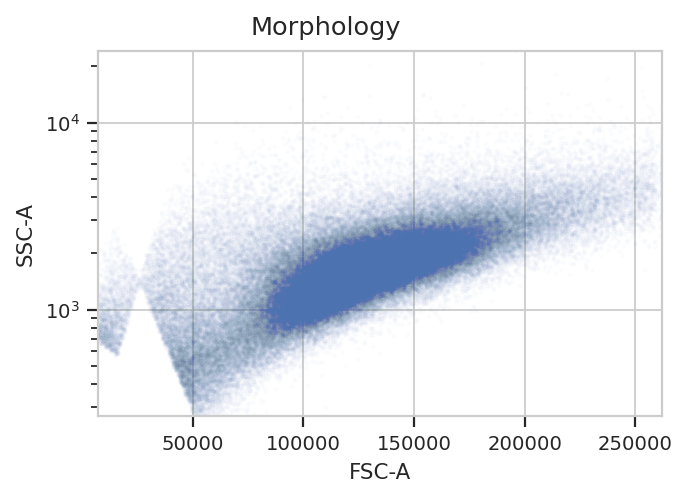

In [4]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log").plot(ex, alpha = 0.01, title = "Morphology")

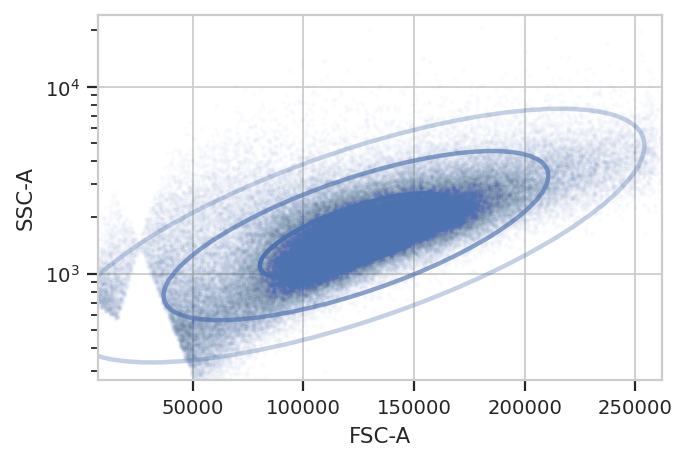

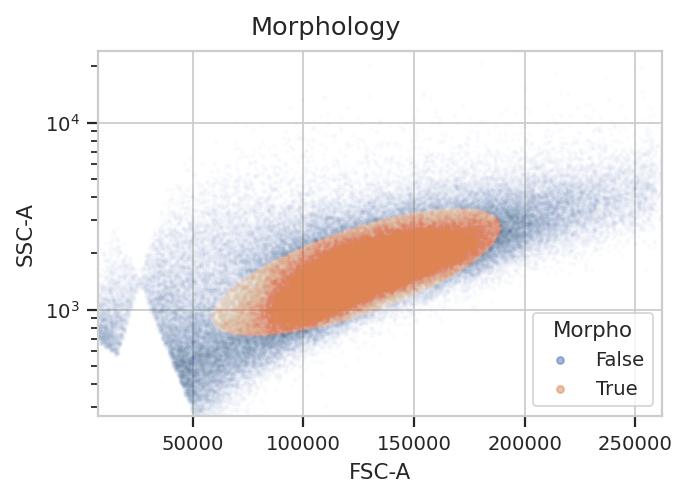

In [5]:
gm_1 = flow.GaussianMixtureOp(name = "Morpho",
                              channels = ["FSC-A", "SSC-A"],
                              scale = {"SSC-A" : "log"},
                              num_components = 1,
                              sigma = 1.5)
gm_1.estimate(ex)
ex_morpho = gm_1.apply(ex)
gm_1.default_view().plot(ex_morpho, alpha = 0.01)

flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log",
                     huefacet = "Morpho").plot(ex_morpho, alpha = 0.01, title = "Morphology")

### Autofluorescence correction 

To account for autofluorescence, we measure a tube of *blank cells* (unstained, untransfected, untransformed -- not fluorescing.)  The autofluorescence operation finds the (arithmetic) median of the blank cells' distributions in the fluorescence channels and subtracts it from all the observations in the experimental data. We specify ``Morpho == True`` to capture the same subset of cells that we are using in our analysis.

The diagnostic plot just shows the fluorescence histograms and the medians.  Make sure that they're unimodal and the median is at the peak.

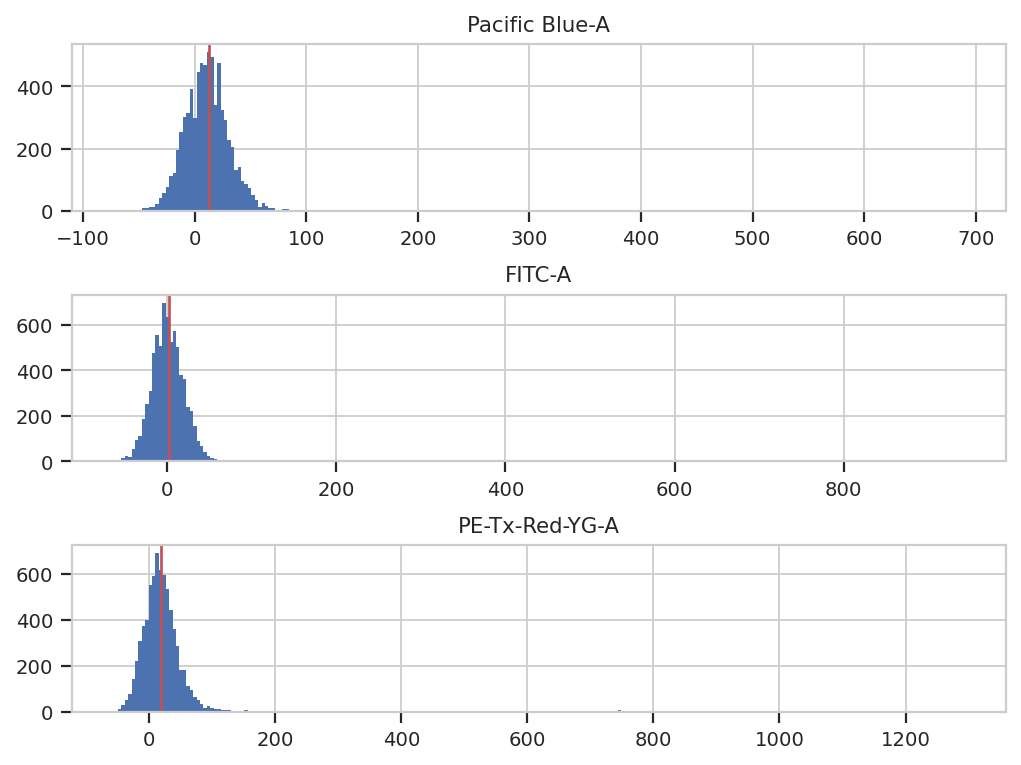

In [6]:
af_op = flow.AutofluorescenceOp()
af_op.blank_file = "controls/Blank-1_H12_H12_P3.fcs"
af_op.channels = ["Pacific Blue-A", "FITC-A", "PE-Tx-Red-YG-A"] 

af_op.estimate(ex_morpho, subset = "Morpho == True")
af_op.default_view().plot(ex_morpho)

In [7]:
ex_af = af_op.apply(ex_morpho)

### Spectral bleedthrough correction

This operation characterizes how much a fluorophore's signal shows up in channels other than the one you are using to detect it.  For example, EYFP is primarily measured in the (yellow) FITC channel, but some signal also shows up in the (red) PE-Texas Red channel.

The controls for this operation are single-fluorescent controls -- either single fluorescent proteins or singly-stained cells.  They should fluoresce brightly, so as to best-characterize bleedthrough.

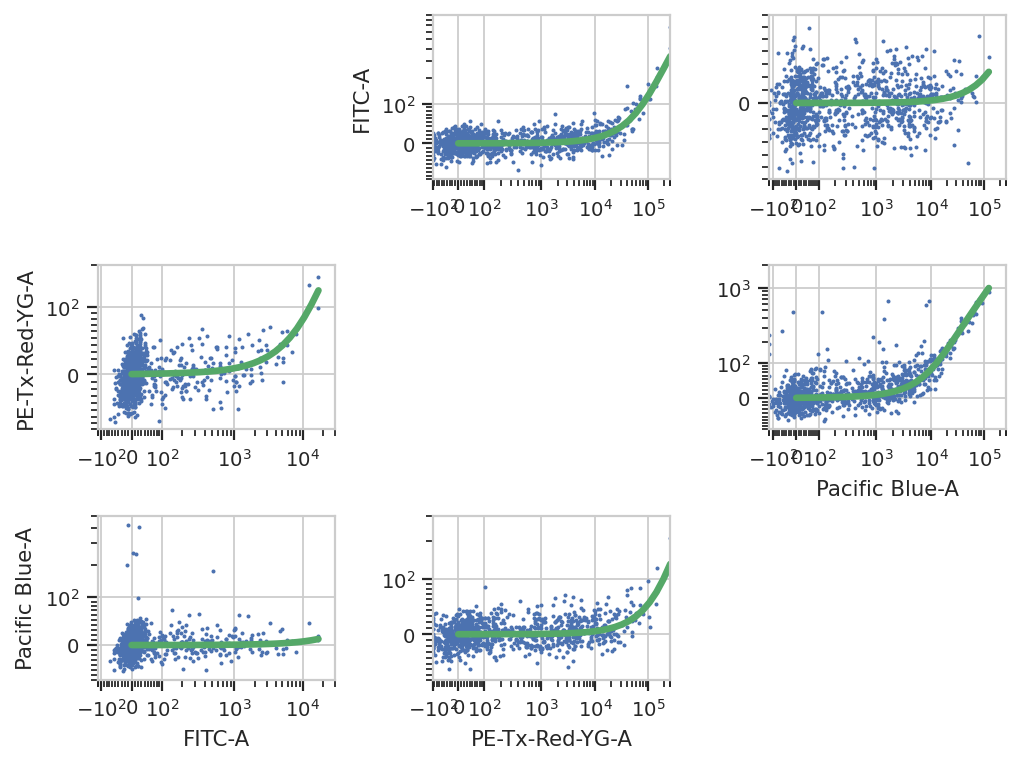

In [8]:
bl_op = flow.BleedthroughLinearOp()
bl_op.controls = {'Pacific Blue-A' : 'controls/EBFP2-1_H9_H09_P3.fcs',
                  'FITC-A' : 'controls/EYFP-1_H10_H10_P3.fcs',
                  'PE-Tx-Red-YG-A' : 'controls/mkate-1_H8_H08_P3.fcs'}

bl_op.estimate(ex_af, subset = "Morpho == True")
bl_op.default_view().plot(ex_af)


In [9]:
ex_bl = bl_op.apply(ex_af)

### Bead Calibration

Unfortunately, the raw measurements from a flow cytometer are sensitive to many factors.  These range from the precise optical configuration, to the laser power, to the PMT voltage, to the last time the instrument was cleaned and calibrated.  Thus, the measurements taken on one instrument are not directly compatible with those taken on another.  (Sometimes, even day-to-day variation on the same instrument is enough to ruin comparisons.)

One way to address this is to calibrate your measurements against a stable, well-characterized calibrant.  My favorite is a set of stable fluorescent beads, such as the Spherotech RCP-30-5As.  This module calibrates measurements to molecules of equivalent fluorophores, which can make calibrations (more) comparable.  Read the beads' documentation for more details.

NB: Adding new beads is easy!  See the `bead_calibration` module's source code.

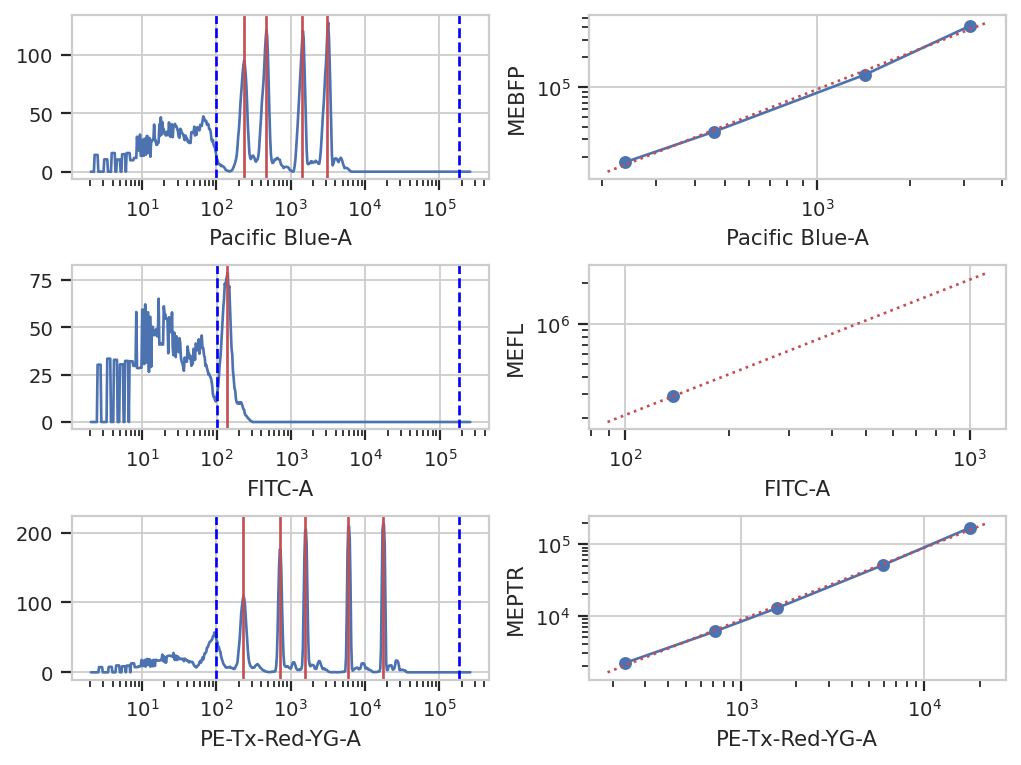

In [10]:
bead_op = flow.BeadCalibrationOp()
bead_op.beads = flow.BeadCalibrationOp.BEADS['RCP-30-5A Lot AA01, AA02, AA03, AA04, AB01, AB02, AC01 & GAA01-R']
bead_op.units = {"Pacific Blue-A" : "MEBFP",
                 "FITC-A" : "MEFL",
                 "PE-Tx-Red-YG-A" : "MEPTR"}

bead_op.beads_file = "controls/BEADS-1_H7_H07_P3.fcs"
bead_op.estimate(ex_bl)

bead_op.default_view().plot(ex_bl)

In [11]:
ex_beads = bead_op.apply(ex_bl)

### Color Translation

At the end of the day, we want to be able to compare signals collected in the yellow channel to signals from the blue and red channels in comparable units.  Unfortunately, different fluorescent proteins mature at different rates, have different quantum efficiencies, etc -- so even if we measure the same absolute fluorescence (in photon flux, say), we still can't say that the number of molecules is the same.

One way around this is to use a biological control where you are releatively certain that the number of molecules *is* the same to compute a conversion factor.  For example, EYFP and mKate and EBFP2 all expressed under the same promoter in the same cell line should produce the same amounts of RNA and comparable amounts of protein.  This module lets you use a set of controls like this to convert between *biological* signals.

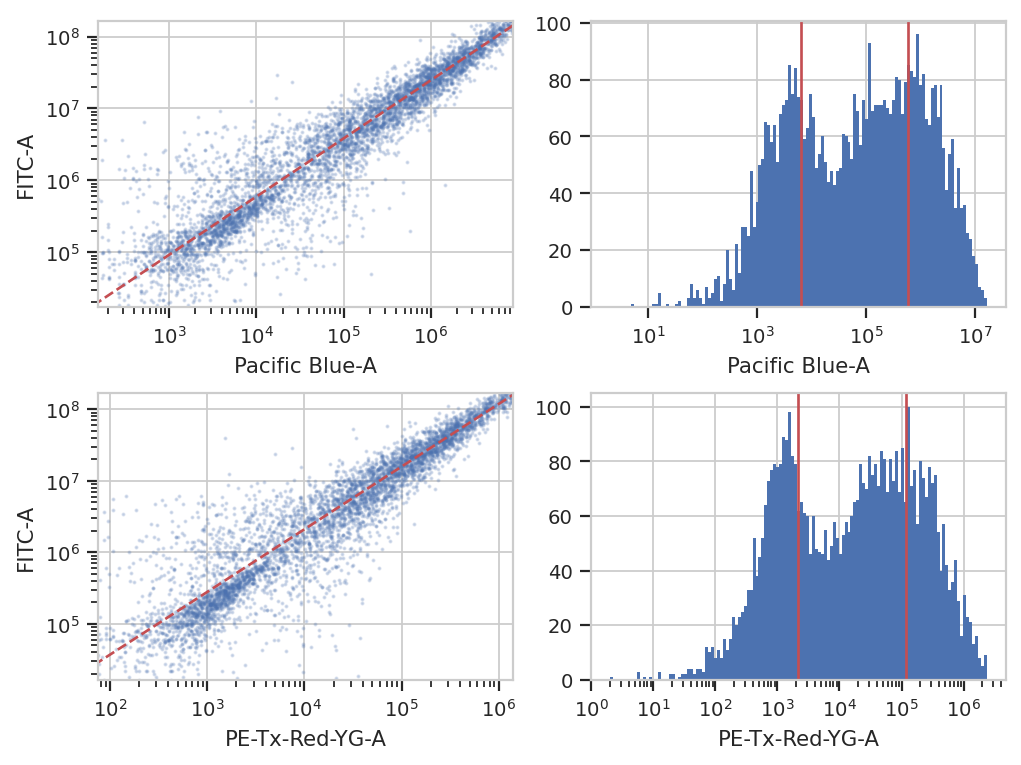

In [12]:
ct_op = flow.ColorTranslationOp()
ct_op.controls = {("Pacific Blue-A", "FITC-A") : "controls/RBY-1_H11_H11_P3.fcs",
                  ("PE-Tx-Red-YG-A", "FITC-A") : "controls/RBY-1_H11_H11_P3.fcs"}
ct_op.mixture_model = True

ct_op.estimate(ex_beads, subset = "Morpho == True")
ct_op.default_view().plot(ex_beads)

In [13]:
ex_calib = ct_op.apply(ex_beads)

### Binned Analysis

As described above, the example data in this notebook is from a transient transfection of mammalian cells in tissue culture.  What this means is that there's a really broad distribution of fluorescence, corresponding to a broad distribution of transfection levels.

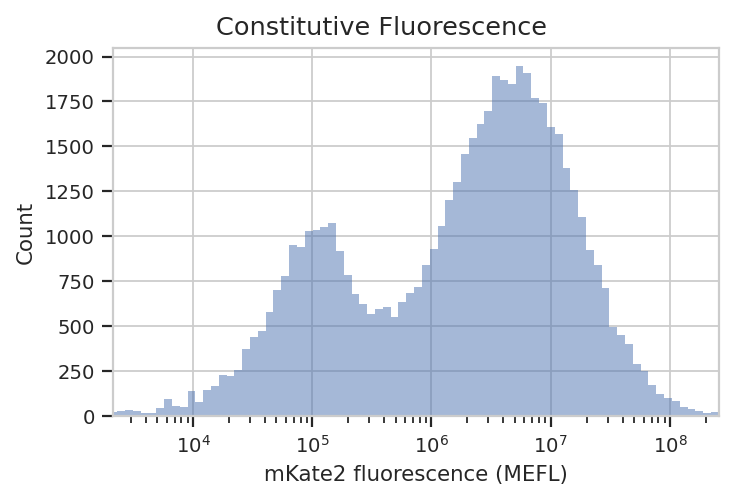

In [14]:
flow.HistogramView(channel = "PE-Tx-Red-YG-A",
                   scale = "log",
                   subset = "Morpho == True").plot(ex_calib,
                                                   title = "Constitutive Fluorescence",
                                                   xlabel = "mKate2 fluorescence (MEFL)")

See?  The left peak is cells that are untransfected; the right peak is cells that were.  The cells that were transfected seem to range from about 3x10^5 MEFL up to 10^8 MEFL, over two orders of magnitude.

The way we handle this data is by dividing the cells into bins depending on their transfection levels.  We find that cells that recieved few plasmids frequently behave differently (quantitatively speaking) than cells that received many plasmids.  The `BinningOp` module applies evenly spaced bins; in this example, we're going to apply them on a log scale, every 0.1 log-units.

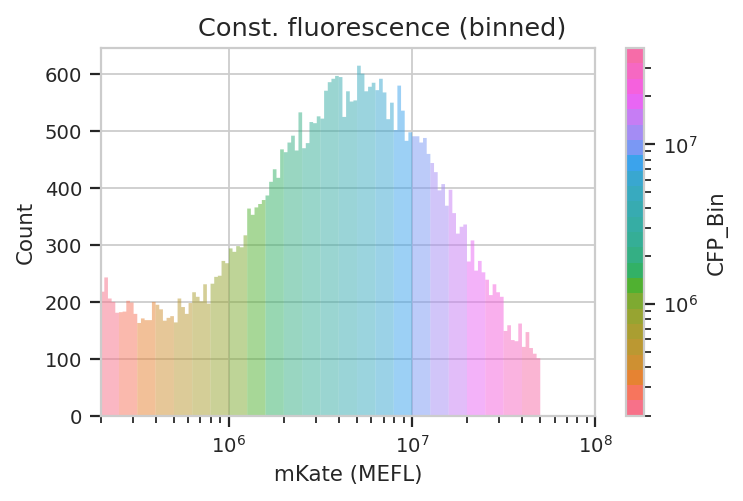

In [15]:
ex_bin = flow.BinningOp(name = "CFP_Bin",
                        bin_count_name = "CFP_Bin_Count",
                        channel = "PE-Tx-Red-YG-A",
                        scale = "log",
                        bin_width = 0.1).apply(ex_calib)

flow.HistogramView(channel = "PE-Tx-Red-YG-A",
                   huefacet = "CFP_Bin",
                   huescale = "log",
                   scale = "log",
                   subset = "Morpho == True & "
                            "PE_Tx_Red_YG_A >= 200000 and CFP_Bin_Count > 1000").plot(ex_bin,
                                                                                      xlabel = "mKate (MEFL)",
                                                                                      title = "Const. fluorescence (binned)",
                                                                                      lim = (2e5, 1e8))

Now we can start our analysis properly.  For each unique combination of [Dox] and bin, we compute four values:
 - The geometric mean of the Pacific Blue channel, the "input fluorescent protein" or IFP
 - The geometric mean of the ratio of IFP and PE-Texas Red channels
 - The geometric mean of the FITC channel, the "output fluorescent protein" or OFP
 - The geometric mean of the ratio of the FITC and PE-Texas Red channels
 
Remember, because we calibrated the measurements, the CFP, IFP and OFP channels are on the same scale, which makes comparisons between them (ratios, etc) meaningful. We can do this entire thing in a single `FrameStatisticsOp` using a lambda expression that returns a ``pandas.Series``:

In [16]:
import pandas as pd
# ex_stats = flow.ChannelStatisticOp(name = "IFP",
#                                    channel = "Pacific Blue-A",
#                                    by = ["Dox", "CFP_Bin"],
#                                    function = flow.geom_mean,
#                                    subset = "Morpho == True and "
#                                             "PE_Tx_Red_YG_A > 200000 and CFP_Bin_Count > 1000").apply(ex_bin)

# ex_stats = flow.FrameStatisticOp(name = "IFP",
#                                  by = ["Dox", "CFP_Bin"],
#                                  function = lambda x: pdflow.geom_mean(x["Pacific Blue-A"] / x["PE-Tx-Red-YG-A"]),
#                                  statistic_name = "geom_mean_per_cfp",
#                                  subset = "Morpho == True and "
#                                           "PE_Tx_Red_YG_A > 200000 and CFP_Bin_Count > 1000").apply(ex_stats)

# ex_stats = flow.ChannelStatisticOp(name = "OFP",
#                                    channel = "FITC-A",
#                                    by = ["Dox", "CFP_Bin"],
#                                    function = flow.geom_mean,
#                                    subset = "Morpho == True and "
#                                             "PE_Tx_Red_YG_A > 200000 and CFP_Bin_Count > 1000").apply(ex_stats)

# ex_stats = flow.FrameStatisticOp(name = "OFP",
#                                  by = ["Dox", "CFP_Bin"],
#                                  function = lambda x: flow.geom_mean(x["FITC-A"] / x["PE-Tx-Red-YG-A"]),
#                                  statistic_name = "geom_mean_per_cfp",
#                                  subset = "Morpho == True and "
#                                           "PE_Tx_Red_YG_A > 200000 and CFP_Bin_Count > 1000").apply(ex_stats)

ex_stats = flow.FrameStatisticOp(name = "Input_Output",
                                 by = ["Dox", "CFP_Bin"],
                                 function = lambda x: pd.Series({"IFP" : flow.geom_mean(x["Pacific Blue-A"]),
                                                                 "IFP/CFP" : flow.geom_mean(x["Pacific Blue-A"] / x["PE-Tx-Red-YG-A"]),
                                                                 "OFP" : flow.geom_mean(x["FITC-A"]),
                                                                 "OFP/CFP" : flow.geom_mean(x["FITC-A"] / x["PE-Tx-Red-YG-A"])}),
                                 subset = "Morpho == True and "
                                          "PE_Tx_Red_YG_A > 200000 and CFP_Bin_Count > 1000").apply(ex_bin)


Let's start with our input fluorescent protein, EBFP2.  Do we see more of it as we increase [Dox]?  Is the response different in different bins (i.e. different transfection levels?)

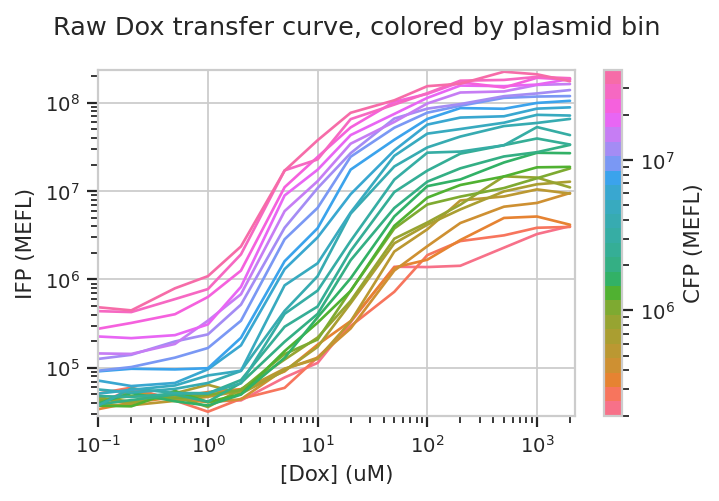

In [17]:
flow.Stats1DView(statistic = "Input_Output",
                 feature = "IFP",
                 variable = "Dox",
                 variable_scale = "log",
                 scale = "log",
                 huefacet = "CFP_Bin",
                 huescale = "log").plot(ex_stats,
                                            xlabel = "[Dox] (uM)",
                                            ylabel = "IFP (MEFL)",
                                            huelabel = "CFP (MEFL)",
                                            title = "Raw Dox transfer curve, colored by plasmid bin")

The answer to both questions is "yes": there is an increase in IFP signal as we increase [Dox], and the precise quantitative character of the curve is different depending on which bin we select.  Of particular interest is how moderately transfected bins (say, 10^5 through 10^6) have greater on-off ratios than bins on either side of the transfection distribution.

---

Does this hold when we normalize by transfection (ie, divide by CFP)?

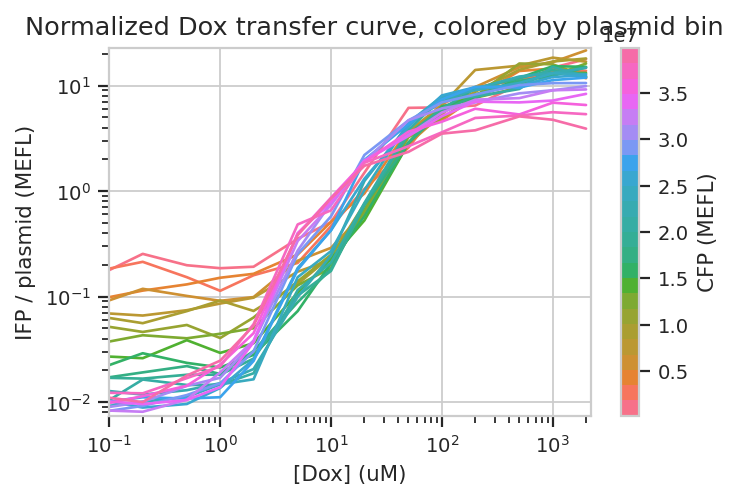

In [18]:
flow.Stats1DView(statistic = "Input_Output",
                 feature = "IFP/CFP",
                 variable = "Dox",
                 scale = "log",
                 variable_scale = "log",
                 huefacet = "CFP_Bin").plot(ex_stats,
                                            xlabel = "[Dox] (uM)",
                                            ylabel = "IFP / plasmid (MEFL)",
                                            huelabel = "CFP (MEFL)",
                                            title = "Normalized Dox transfer curve, colored by plasmid bin")

Sure enough, the moderately trasnfected curves fall right on top of eachother, making it really obvious that the fold induction of different bins is different.

---

Things get really interesting when we start plotting different features against eachother. In the example below, we plot how the geometric mean of each bin's IFP and OFP change as we vary Dox.  There is one line plotted per bin.

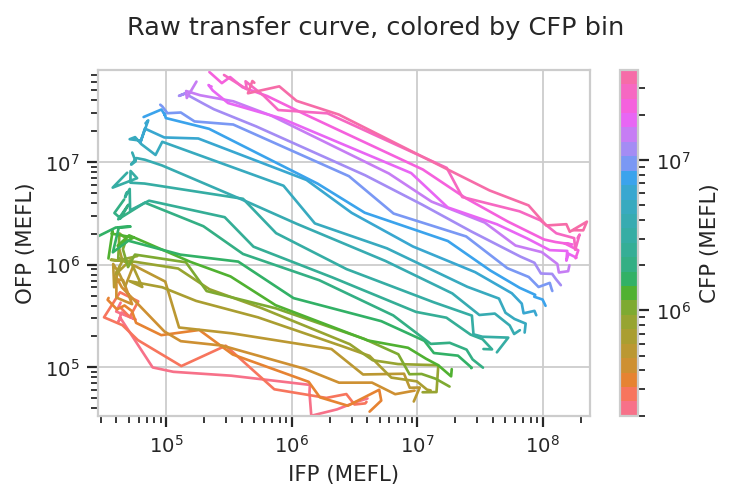

In [19]:
flow.Stats2DView(statistic = "Input_Output",
                 xfeature = "IFP",
                 yfeature = "OFP",
                 variable = "Dox",
                 xscale = "log",
                 yscale = "log",
                 huescale = "log",
                 huefacet = "CFP_Bin").plot(ex_stats,
                                            xlabel = "IFP (MEFL)",
                                            ylabel = "OFP (MEFL)",
                                            huelabel = "CFP (MEFL)",
                                            title = "Raw transfer curve, colored by CFP bin")

We can do the same thing with the scaled statistics, too.

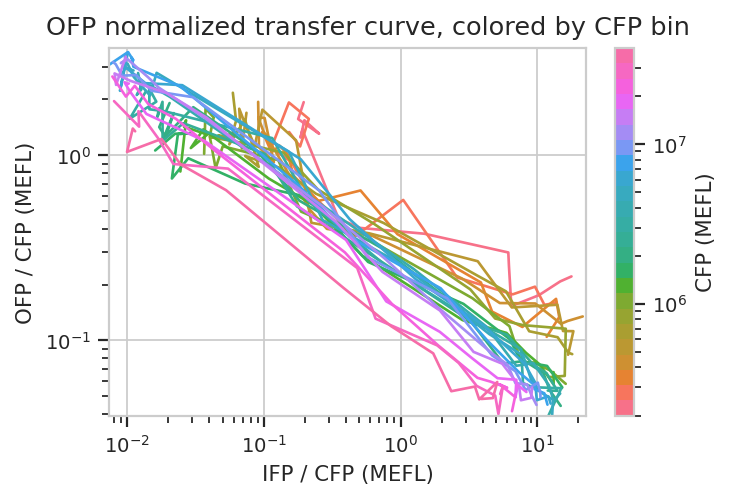

In [20]:
flow.Stats2DView(statistic = "Input_Output",
                 xfeature = "IFP/CFP",
                 yfeature = "OFP/CFP",
                 variable = "Dox",
                 xscale = "log",
                 yscale = "log",
                 huescale = "log",
                 huefacet = "CFP_Bin").plot(ex_stats, 
                                            xlabel = "IFP / CFP (MEFL)",
                                            ylabel = "OFP / CFP (MEFL)",
                                            huelabel = "CFP (MEFL)",
                                            title = "OFP normalized transfer curve, colored by CFP bin")